# Number Classification (Multiclass Classification)


In this notebook, I will building a neural network capable of identifying numbers from 0-9. I will be using multiclass classification neural network utilizing the Softmax Regression Algorithm. In addition, I will be using Kera's in-built datasets, specifically the MNIST dataset. 

#### IMPORTS

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Dataset Preprocessing

Lets import the dataset.

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

Lets get a bit more familiar with our dataset. We will start by printing out each variable, `x` and `y`, and see what it contains.

In [3]:
print(f"The first element of x in the training set is: {x_train[0]}")

The first element of x in the training set is: [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0

In [4]:
print(f"The first element of y in the training set is: {y_train[0]}")
print(f"The last element of y in the training set is: {y_train[-1]}")

The first element of y in the training set is: 5
The last element of y in the training set is: 8


Let's also get familiar with the dimensions of `x` and `y`.

In [5]:
print(f"The shape of x is: {x_train.shape}")
print(f"The shape of y is: {y_train.shape}")

The shape of x is: (60000, 28, 28)
The shape of y is: (60000,)


After analyzing the dataset, we can see that this training dataset consists of 60,000 examples, with each example being $28 \times 28$. The `x_train` dataset contains the the images as NumPy arrays while the `y_train` dataset contains the actual classification of each image.

Here is a few examples of what the dataset contains:

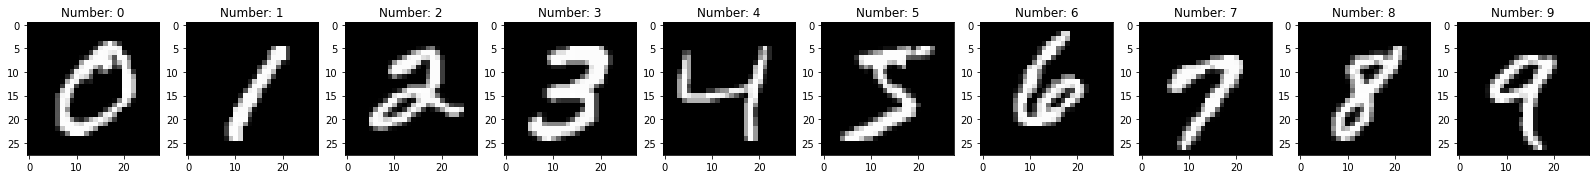

In [6]:
numbers = 10
f, ax = plt.subplots(1, numbers, figsize=(28,28))

for i in range(0, numbers):
    sample_num =  x_train[y_train == i][0]
    ax[i].imshow(sample_num, cmap="gray")
    ax[i].set_title(f"Number: {i}")

The documentation for the dataset also lets us know that the digits are grayscale images, with pixel values **ranging from 0 to 255**. To improve the processing time (speed) of the finding a good model, we will **normalize** our dataset. This will be especially helpful when running the gradient descent algorithm or the Adaptive Moment Estimation (Adam) algorithm.

In [7]:
# Normalize data (since max value is 255, we divide all elements by 255 so we get a range of values from 0 to 1)
x_train = x_train / 255.0
x_test = x_test / 255.0

We will also reshape our data. Since each example is (28,28) in shape, we will flatten it and make it one long vector instead of passing a matrix as our input.

In [8]:
# Reshape data
print(f"Before reshape: {x_train.shape}")
x_train = x_train.reshape(x_train.shape[0], -1) # the -1 basically means "infer the length based on the remaining dimensions. ex.) 28 by 28"
x_test = x_test.reshape(x_test.shape[0], -1)
print(f"After reshape: {x_train.shape}")

Before reshape: (60000, 28, 28)
After reshape: (60000, 784)


## 1. Creating the model

Now we will construct our model. Since our images are $28 \times 28$, this gives us $784$ inputs. Here is the plan:

![Model Plan](./modelPlan.png)

For numerical stability, the softmax algorithm will be grouped with the loss function rather than grouping it the output layer during training. 

In [9]:
model = tf.keras.models.Sequential([
        tf.keras.Input(shape=(784,)),
        tf.keras.layers.Dense(units=128, activation="relu", name="Layer1"),
        tf.keras.layers.Dense(units=128, activation="relu", name="Layer2"),
        tf.keras.layers.Dense(units=10, activation="linear", name="Layer3"),
])

**Note:** It is always trial and error when finding the number of neurons/units we need in each layer. I found that using 128 units worked well for this experiment. Our last layer has 10 units to represent the output labels (0-9).

Let us see a summary of our model so we have a better intuition of what is going on in our model:

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 128)               100480    
                                                                 
 Layer2 (Dense)              (None, 128)               16512     
                                                                 
 Layer3 (Dense)              (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
_________________________________________________________________


Below is to verify that our calculations above match tensorflows calcuations:

In [11]:
[layer1, layer2, layer3] = model.layers

W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (784, 128), b1 shape = (128,)
W2 shape = (128, 128), b2 shape = (128,)
W3 shape = (128, 10), b3 shape = (10,)


Now, we will move onto the loss and cost functions!

## 2. Loss and cost functions

Now, we will define our loss function. We will use the `SparseCategoricalCrossentropy` loss function since we have 10 possible output labels. Additionally, we will be including the softmax with the loss calculation by adding `fromlogits = True` in the loss function. Last but not least, we will be using the Adam algorithm to optimize the processing time since it is much faster than the traditional gradient descent.

In [12]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

## 3. Gradient Descent / Adam Algorithm

Now, we train the model by giving `x_train` and `y_train`. We will train the model for 4 epochs.

In [13]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.2283 - accuracy: 0.9326
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0955 - accuracy: 0.9706
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0684 - accuracy: 0.9788
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0531 - accuracy: 0.9830
Epoch 5/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0411 - accuracy: 0.9867


## Testing Model

Lets see how accurate our model by testing it on our test dataset

In [14]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f"Loss = {loss}")
print(f"Accuracy of Model = {accuracy*100:.2f}%")

313/313 [==============================] - 1s 1ms/step - loss: 0.0974 - accuracy: 0.9736
Loss = 0.09741924703121185
Accuracy of Model = 97.36%


Now, we will get all the predictions for all the testing dataset 

In [15]:
predictions = model.predict(x_test) # gets the predictions from linear function
predictions_prob = tf.nn.softmax(predictions).numpy() # this changes the predictions into probabilities
predict_num = np.argmax(predictions_prob, axis=1) # select the largest probability as the prediction
print(predict_num)

313/313 [==============================] - 0s 1ms/step
[7 2 1 ... 4 5 6]


Here are all the indexes of testing dataset where the model made incorrect predictions

In [16]:
# find all examples with incorrect predictions
wrong_pred_idx = []
for i in range(len(x_test)):
    if predict_num[i] != y_test[i]:
        wrong_pred_idx.append((i, np.max(predictions_prob[i])))

if len(wrong_pred_idx) != 0:
    print(f"Number of incorrect predictions: {len(wrong_pred_idx)}")
else:
    print("All predictions correct!")


Number of incorrect predictions: 264


In [17]:
print(wrong_pred_idx)

[(8, 0.5988667), (92, 0.8730682), (124, 0.87716115), (158, 0.84119856), (247, 0.9989095), (274, 0.75958145), (320, 0.51852036), (321, 0.9902361), (340, 0.9854371), (391, 0.68795854), (445, 0.92417306), (495, 0.9924759), (582, 0.9720944), (591, 0.54462737), (619, 0.88473934), (655, 0.61022323), (674, 0.8203207), (684, 0.9779318), (720, 0.97646755), (810, 0.5636043), (900, 0.5708393), (951, 0.6941189), (956, 0.792135), (1014, 0.96662337), (1039, 0.459889), (1044, 0.9058325), (1112, 0.9997979), (1128, 0.582387), (1156, 0.51421463), (1178, 0.42114294), (1182, 0.88119566), (1226, 0.99852353), (1232, 0.26783583), (1242, 0.5966659), (1247, 0.553849), (1260, 0.8298892), (1299, 0.8693336), (1319, 0.7949218), (1331, 0.90157807), (1393, 0.96180606), (1414, 0.84463346), (1429, 0.79117495), (1441, 0.68093985), (1522, 0.5884643), (1530, 0.82691765), (1549, 0.7774274), (1553, 0.9742848), (1554, 0.46601617), (1570, 0.6638654), (1671, 0.8717653), (1681, 0.99618894), (1686, 0.4908056), (1709, 0.46778873

These are the five least confident predictions the model makes.

In [18]:
def get_five_worst_predictions():
    f, ax = plt.subplots(1, 5, figsize=(28,28))
    incorrect_lst = wrong_pred_idx.copy()
    worst_pred = []

    for i in range(5):
        least_confidence_ex = min(incorrect_lst, key= lambda j : j[1])
        worst_pred.append(least_confidence_ex)
        incorrect_lst.remove(least_confidence_ex)
    
    for j in range(5):
        num =  x_test[worst_pred[j][0]].reshape(28,28)
        num_predicted = predict_num[worst_pred[j][0]]
        num_actual = y_test[worst_pred[j][0]]
        probability = worst_pred[j][1]
        ax[j].imshow(num, cmap="gray")
        ax[j].set_title(f"Predicted Number: {num_predicted}\nActual Number: {num_actual}\nProbability: {probability:.4f}")

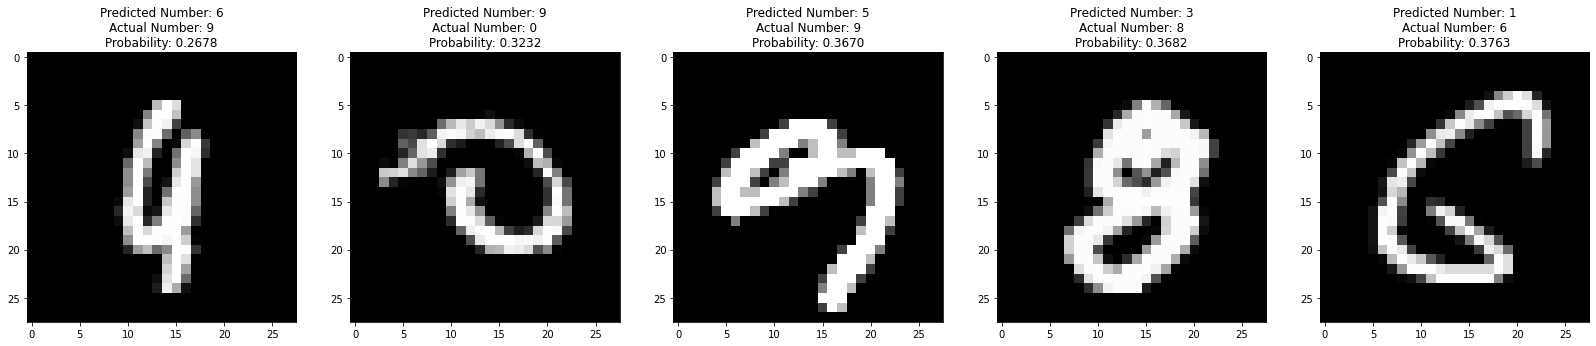

In [19]:
get_five_worst_predictions()

We can see that the digits are poorly drawn, hence the lack of confidence in the algorithm. We could increase the number of epochs so we can identify these odd handwritten digits but then we increase the chance of overfitting to our data and will not generalize to any new examples we add to the testing set. 

## Save the model

In [20]:
model.save('numClassification.model')

INFO:tensorflow:Assets written to: numClassification.model\assets


INFO:tensorflow:Assets written to: numClassification.model\assets
